In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle/

!cp kaggle.json ~/.kaggle/

!ls ~/.kaggle

kaggle.json


In [ ]:
!cd ~/ # 경로 이동 (~:루트경로로 이동)

In [ ]:
!ls -a # 해당 경로 목록 전부(-a: 숨김파일까지) 확인

.  ..  .config	kaggle.json  sample_data


In [ ]:
!ls ~/.kaggle -al # 해당 경로 목록 상세정보까지(-al: 권한정보, 날짜) 확인

total 16
drwxr-xr-x 2 root root 4096 Mar 17 05:32 .
drwx------ 1 root root 4096 Mar 17 05:30 ..
-rw-r--r-- 1 root root   64 Mar 17 05:32 kaggle.json


In [ ]:
# 파일 권한 변경 : 읽기, 쓰기, 실행 (rwx)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prasunroy/natural-images 


 97% 333M/342M [00:03<00:00, 109MB/s]
100% 342M/342M [00:03<00:00, 107MB/s]


In [ ]:
!unzip -q natural-images.zip

In [ ]:
import os

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
folder_path = '/content/natural_images'
label_names = os.listdir(folder_path)
label_names

['airplane', 'dog', 'fruit', 'person', 'motorbike', 'car', 'cat', 'flower']

In [ ]:
dataset = {} # 카테고리명 : [이미지1경로, 이미지2경로, ...]
for label_name in label_names:
  img_folder_path = folder_path + '/' + label_name
  img_names = os.listdir(img_folder_path)
  dataset[label_name] = img_names

dataset

{'airplane': ['airplane_0676.jpg',
  'airplane_0673.jpg',
  'airplane_0104.jpg',
  'airplane_0579.jpg',
  'airplane_0078.jpg',
  'airplane_0639.jpg',
  'airplane_0518.jpg',
  'airplane_0029.jpg',
  'airplane_0013.jpg',
  'airplane_0478.jpg',
  'airplane_0707.jpg',
  'airplane_0220.jpg',
  'airplane_0641.jpg',
  'airplane_0373.jpg',
  'airplane_0309.jpg',
  'airplane_0084.jpg',
  'airplane_0662.jpg',
  'airplane_0050.jpg',
  'airplane_0161.jpg',
  'airplane_0022.jpg',
  'airplane_0046.jpg',
  'airplane_0417.jpg',
  'airplane_0396.jpg',
  'airplane_0413.jpg',
  'airplane_0567.jpg',
  'airplane_0422.jpg',
  'airplane_0273.jpg',
  'airplane_0047.jpg',
  'airplane_0228.jpg',
  'airplane_0018.jpg',
  'airplane_0278.jpg',
  'airplane_0168.jpg',
  'airplane_0378.jpg',
  'airplane_0200.jpg',
  'airplane_0492.jpg',
  'airplane_0574.jpg',
  'airplane_0394.jpg',
  'airplane_0711.jpg',
  'airplane_0282.jpg',
  'airplane_0160.jpg',
  'airplane_0310.jpg',
  'airplane_0154.jpg',
  'airplane_0267.jpg',

In [ ]:
label2index = {'airplane' : 0, 'car' : 1 , 'cat' : 2 , 'dog' : 3,
               'flower' : 4, 'fruit' : 5, 'motorbike' : 6, 'person' : 7}

images, labels = [], []

In [ ]:
def resize(img, img_size):
  if(img.shape[1] > img.shape[0]) : 
    ratio = img_size/img.shape[1]
  else :
    ratio = img_size/img.shape[0]

  img = cv2.resize(img, dsize=(0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_LINEAR) # interpolation : 고간법 - 주변을 참고해서 채움

  return img

In [ ]:
def padding(img, img_size):
  w, h = img.shape[1], img.shape[0]

  dw = (img_size-w)/2 # img_size와 w의 차이
  dh = (img_size-h)/2 # img_size와 h의 차이

  M = np.float32([[1,0,dw], [0,1,dh]])  #(2*3 이차원 행렬)
  img_re = cv2.warpAffine(img, M, (img_size, img_size))

  return img_re

In [ ]:
# 이미지 리사이즈
# 1. 이미지 하나씩 읽어들여서
# 2. 리사이즈한다음
# 3. images, labels 생성

img_size = 224

images = []
labels = []

for label, img_paths in dataset.items():
  for img_path in img_paths:
    img_path = folder_path + '/' + label + '/' + img_path
    img = cv2.imread(img_path)
    img_re = resize(img, img_size)
    img_pre = padding(img_re, img_size)

    images.append(img_pre)
    labels.append(label2index[label])


6899 6899
2


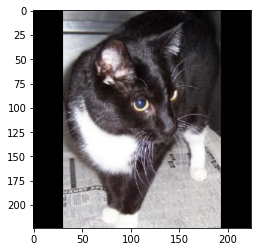

In [ ]:
print(len(images), len(labels))
check_num = 5588

plt.imshow(cv2.cvtColor(images[check_num], cv2.COLOR_BGR2RGB))
print(labels[check_num])

In [ ]:
# 리스트인 images, labels ndarray로 변환
images, labels = np.array(images), np.array(labels)

In [ ]:
images.shape, labels.shape

((6899, 224, 224, 3), (6899,))

## Zero Centering

In [ ]:
# images, labels -> x_train, y_train, x_test, y_test로 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size= 0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5519, 224, 224, 3), (1380, 224, 224, 3), (5519,), (1380,))

In [ ]:
# trainset으로 mean_img 계산하고, 
# testset은 trainset mean img로 
compute_mean = lambda image : np.mean(image, axis=0)
mean_img = compute_mean(X_train)
mean_img.shape

(224, 224, 3)

In [ ]:
# 메모리 문제가 있다면 int8로 변환(근사값으로 사용)
mean_img = mean_img.astype('int8') 

In [ ]:
zero_train = X_train - mean_img
zero_test = X_test - mean_img

## 데이터 저장

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/image_recognition/ayun/'

In [ ]:
with open(folder_path+'X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f)

In [ ]:
with open(folder_path+'y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open(folder_path+'X_test.pickle', 'wb') as f:
    pickle.dump(X_test, f)

In [ ]:
with open(folder_path+'y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
import pandas as pd

train_img = pd.read_pickle(folder_path+'X_train.pickle')
test_img = pd.read_pickle(folder_path+'X_test.pickle')
train_label = pd.read_pickle(folder_path+'y_train.pickle')
test_label = pd.read_pickle(folder_path+'y_test.pickle')

In [ ]:
train_img.shape, test_img.shape, train_label.shape, test_label.shape

((5519, 224, 224, 3), (1380, 224, 224, 3), (5519,), (1380,))